#                                   Description Triangle Algorithm                                   #
                                        
####################### each crownstone #######################                           

1a: Scan for surrounding nodes, store the UUID and the RSSI, filter on RSSI if needed \
1b: Communicate with all the surrounding nodes, request RSSI and update the edges in the formed array/table \
#------------------->: Edge(node_src/node_dst/RSSI) \
2: If 2 edges are formed, Try making a trinagle, by asking both edge_Dst if they can see each other \
2a Example: start at the top of the list, take a = list(i) and b = list(i+1) / two best connections, like: c1/c2/-45 and c1/c3/-47 \
2b send message to both Crownstones, in this example c2 and c3, to ask if they can see each other in there surounding nodes list \
2c If there is a node/vertice match, make a triangle with pointers to the edges \
#-------------------> Triangle(edgeP1/edgeP2/edgeP3) \

####################### Communication ####################### 
                                        
Between two Crownstones: \
1: Request: check his connections on a specific Crownstone \
<->  \
2: Answer: specific Crownstone connection values in format: cX(already known)/cY/RSSI \

Mesh message between all Crownstones:\ 
1: Global request for exchange of triangles to Hub \
2: Every Cronwstone sends its best triangles (max 3-5) \

####################### Processing/Mapping ####################### 

All triangles will be send to the hub. The hub will further process the triangles to a map.


In [24]:
# Run once to install all packages needed
# %pip install ipympl, matplotlib, networkx, pandas, numpy 

In [25]:
%matplotlib widget

import random
from random import normalvariate
import math
from math import sqrt, log10
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
import networkx as nx
from IPython.display import display, clear_output
import ipywidgets as widgets
from collections import Counter
import threading
import time

In [26]:
#-----------------------------------------#

random.seed(7)
# num_nodes = 5

#-----------------------------------------#

In [27]:
# Plot the reference node network
def compareGraph3D(Network_Dict, RefNode_List):
    G = nx.Graph()

    i = 0
    for nodeID, edges in Network_Dict.items():
        G.add_node(nodeID, pos=RefNode_List[i])
        for edge in edges:
            G.add_edge(edge.src.uuid, edge.dst.uuid, Rssi=edge.rssi)
        i += 1

    pos = nx.get_node_attributes(G, 'pos')
    rssi = nx.get_edge_attributes(G, "Rssi")

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')  # Create a 3D axis

    # Draw nodes as scatter plot and text labels
    for nodeID, coords in pos.items():
        ax.scatter(*coords, c="blue", s=100, marker='o')
        ax.text(*coords, f'Node {nodeID}\n({coords[0]}, {coords[1]}, {coords[2]})', ha='center', va='bottom')

    # Draw edges in 3D
    for edge in G.edges():
        xs, ys, zs = zip(*[pos[edge[i]] for i in range(2)])
        ax.plot(xs, ys, zs, color='black')
        rssi_value = rssi.get(edge, "")
        ax.text(sum(xs)/2,sum(ys)/2,sum(zs)/2, f"{rssi_value:.3f}", color='red')

    ax.set_title("Node plot with signal strength (RSSI) (3D)")
    plt.show()

# Convert the length between two coordinates to RSSI
def distance_to_rssi(nodeCoord1, nodeCoord2):
    c1x, c1y, c1z = nodeCoord1
    c2x, c2y, c2z = nodeCoord2
    distance = math.sqrt((c1x-c2x)**2 + (c1y-c2y)**2 + (c1z-c2z)**2)
    # noise = normalvariate(0, sqrt(20))
    noise = 0
    # rssi = -70 - 10 * 2.0 * log10(distance) + noise
    return distance
    # return rssi


# Convert RSSI into distance, for now a log function or later try neural net conversion
def rssi_to_distance(rssi):
    # return (10**((-rssi-70)/(20)))
    return rssi

In [28]:
# Node class, which represents a individual Crownstone
class Node:

    def __init__(self, HWuuid: str):
        self.uuid = HWuuid
        self.coord = (0,0,0)
        self.SurNodes = [] # list of (node reference, rssi)
        self.adjEdgeList = []
        self.oppEdgeList = []
        self.triangleList = []
        self.adjTrianglesDict = {}
   
    def __repr__(self):
        return str(self)
    
    def __str__(self) -> str:
        edges_str = ', '.join(map(str, self.adjEdgeList))
        triangles_str = '\n'.join(map(str, self.triangleList))
        nodes_str = ', '.join(map(str, [node.uuid for node, rssi in self.SurNodes])) 
        oppos_str = ', '.join(map(str, self.oppEdgeList)) 
        line = "------------------------------------------------------------------------------------------------\n"
        return f"{line}Node uuid={self.uuid}:{self.coord} [:] Surrounding Nodes= {nodes_str}, Edgelist= {edges_str}\n\nTriangleList:\n{triangles_str}\n\nOpposite edges={oppos_str} [:]\n"
    
    # Print all node information
    def printNodeInfo(self):
        print(self)
        if len(self.adjTrianglesDict) == 0:
            print("No adj triangles dict")
            return
        
        print(f"Adjacent triangles of {self.uuid}:") 
        for edge, adj_list in self.adjTrianglesDict.items():
            print(f"Edge {edge.id}:")
            for adj in adj_list:
                print(adj)
        print("------------------------------------------------------------------------------------------------\n")
      
    def compare(self, other: object):
        return self.uuid == other.uuid
    
    # Initial scan for surrounding nodes in the environment 
    def scanSurroundings(self, network_edges):
        surNodeSet = set()
        for edge in network_edges[self.uuid]:
            surNodeSet.add((edge.dst,edge.rssi))
        self.SurNodes = sorted(surNodeSet, key=lambda x: x[1], reverse=True)

    # Node search request for searched_Node at target_node
    def requestNodeSearch(self, target_node, searched_Node):
        # send BLE message to target and wait for response
        found = target_node.nodeSearch(searched_Node)
        if (found == False):
            print("Node NOT visible")
        else:
            return found # (Node, RSSI)

    # NodeSearch response, checks if requested node is visible in surroundings
    def nodeSearch(self, checkFor: object) -> tuple:
        for surNode in self.SurNodes:
            if surNode[0] == checkFor:
                return surNode
        return False
    
    # Checks if edge is in current list of edges
    def checkEdge(self, check_edgeDst):
        for edge in self.adjEdgeList:
            if edge.dst == check_edgeDst:
                return edge
        return False
    
    # Make a new edge from the supplied nodes and add it to the adjEdgeList if it does not exist already
    def addEdge(self, node1, node2, rssi):
        # check if Edge not already exist
        if self.checkEdge(node2) == False:
            newEdge = Edge(node1, node2, rssi)
            self.adjEdgeList.append(newEdge)
            return True
        else:
            # print("Duplicate!")
            return False

    # Creates an edge with other_sur by making a requestNodeSearch() for itself at other_sur.
    # The edge will be stored in the adjacent edge list, it uses the rssi of other_sur. 
    # List will be sorted due to sorted sur_nodes
    def createEdgeWith(self, other_Sur: tuple):
        check = self.requestNodeSearch(other_Sur[0],self)
        if check == False:
            print("Can not form edge, Node not visible!")
            return False
        else:
            return self.addEdge(self,other_Sur[0],other_Sur[1])
    
    # Check if triangle is already added to internal trianglelist
    def checkTriangle(self, checkTriangle):
        for triangle in self.triangleList:
            if triangle == checkTriangle:
                return True
        return False
    
    # Internal triangle/opposite_edge search in all triangles of the trianglelist
    def triangleSearch(self, opposite_edge):
        for triangle in self.triangleList:
            if triangle.hasEdge(opposite_edge):
                return triangle
        return False  
    
     # Triangle search request for target
    def requestTriangleSearch(self, target_Node, searched_Edge):
        # send BLE message to target and wait for response
        return target_Node.triangleSearch(searched_Edge)

    # Make a new triangle from the supplied edges and add it to the trianglist if it does not exist already, 
    def addTriangle(self, edge1,edge2,common_edge, max_triangles):
        temp = Triangle(edge1,edge2,common_edge)
        # check if triangle not already exist
        if self.checkTriangle(temp) == False and temp.area != 0:
            self.oppEdgeList.append(common_edge)
            self.oppEdgeList.sort(key=lambda x: x.rssi,reverse=False) # rssi less negative better,set True
            self.triangleList.append(temp)
            self.triangleList.sort(key=lambda x: x.area, reverse=False)
            return True
        else:
            # print("Duplicate!")
            return False

    # create temporary triangle to make altitude and angle calculations    
    def createTempTriangle(self, defaultOtherNode, otherNode):
        checkForOther = self.requestNodeSearch(defaultOtherNode,otherNode)
        checkForDef = self.requestNodeSearch(otherNode,defaultOtherNode)
        if checkForOther == False or checkForDef == False:
            return False
        if checkForOther[0].compare(otherNode) and checkForDef[0].compare(defaultOtherNode):
            common_edge = Edge(defaultOtherNode,otherNode,checkForDef[1])       
            temp = Triangle(Edge(self,defaultOtherNode,self.nodeSearch(defaultOtherNode)[1]),Edge(self,otherNode,self.nodeSearch(otherNode)[1]),common_edge)
            return temp
        else:
            return False
        
    # Triangle search request for target
    def requestTempTriangle(self, target_Node, defaultNode, otherNode):
        # send BLE message to target and wait for response
        return target_Node.createTempTriangle(defaultNode,otherNode)

    # Creates a Triangle with self, dst1 and dst2, by making a requestNodeSearch() at dst1 for dst2, and at dst2 for dst1.
    # If there is mutual agreement, an edge between dst1 and dst2 will be made and stored in opposite edge list. 
    # The three edges will be added togheter to form a new triangle
    def createTriangleWith(self, edge1, edge2, max_triangles):
        dst1, dst2 = edge1.dst, edge2.dst

        if self.compare(dst1) or self.compare(dst2):
            print("Can not make Triangle with itself")
            return False
        
        checkForDst2 = self.requestNodeSearch(dst1,dst2)
        checkForDst1 = self.requestNodeSearch(dst2,dst1)
        if checkForDst2 == False or checkForDst1 == False:
            print("Triangle not possible, no common edge")
            return False
        if checkForDst2[0].compare(dst2) and checkForDst1[0].compare(dst1):
            common_edge = Edge(dst1,dst2,checkForDst1[1])
            return self.addTriangle(edge1,edge2,common_edge, max_triangles)


    # This procedure will walk all the nodes and will make N triangles. routine: iterate surnodes, make edge from first, add them to edgelist, 
    # check if edge sees other edge, if True, form edges and make triangle, add triangle to trianglelist
    def triangleProcedure(self, max_triangles):
        surCount = len(self.SurNodes)
        # self.triangleList = array(max_triangles) in C++ allocate array of max_triangles 
        for i in range(surCount):
            for j in range(i+1, surCount):
                self.createEdgeWith(self.SurNodes[i]) # tuple(node,rssi)
                self.createEdgeWith(self.SurNodes[j])
                edgeP1 = self.checkEdge(self.SurNodes[i][0]) # search on dst node
                edgeP2 = self.checkEdge(self.SurNodes[j][0]) 
                self.createTriangleWith(edgeP1,edgeP2, max_triangles)
                if len(self.triangleList) == max_triangles:
                    # TODO: replace when lower weight, max_triangles
                    return
    
    # Links all triangles from trianglelist to individual edges from the edgelist, so edge(AB) has adj
    def createAdjTriangles(self):
        if len(self.adjEdgeList) == 0 or len(self.triangleList) == 0:
            print("NO edges or triangles")
            return False 
        
        triangle_dict = {}
        for base_edge in self.adjEdgeList:
            for triangle in self.triangleList:
                if triangle.hasEdge(base_edge):
                    adjTriangle = Adjacent(triangle)
                    if base_edge not in triangle_dict:
                        adjTriangle.setCoord((base_edge.dst.uuid,base_edge.dist))
                        triangle_dict[base_edge] = [adjTriangle]
                    else:
                        triangle_dict[base_edge].append(adjTriangle)          
        self.adjTrianglesDict = triangle_dict
    

    # ABC and ABD: From the two adjacent nodes C and D, get the height and xpos of the altitude, calculate dXpos
    # Get the distance between C and D, together with dXpos calculate the translation with pythagoras.
    # Dihedral angle calculation with Triangle()
    def getMapAngle(self, defaultOtherNode, otherNode,base_altiX,altiX,base_altiH,altiH):
        reqTri = self.triangleSearch(Edge(defaultOtherNode,otherNode,0)) # first check internal
        if reqTri == False:
            # call make temp triangle, for calculation of altitude -> angle
            reqTri = self.createTempTriangle(defaultOtherNode,otherNode)
            if reqTri == False:
                return False

        nodeDist = reqTri.edges[2].dist
        deltaX = abs(base_altiX - altiX)
        pyth = max(0, nodeDist**2 - deltaX**2)

        translation = math.sqrt(pyth)
        a, b, c = translation, base_altiH, altiH
        p = max(-1, min(1, (b**2 + c**2 - a**2) / (2 * b * c)))
        mapAngle = np.rad2deg(np.arccos(p)) 
        return mapAngle
    

    # Requests altitude position and height from the askNode, for example: you are A in triangle ABC, base_edge AB, askNode C, check if it has triangle with the values for altitude information 
    def mapAltiRequest(self, askNode, base_edge):
        reqTri = self.requestTriangleSearch(askNode, base_edge)
        if reqTri == False:
            # call make temp triangle at target_node, for calculation of altitude -> angle
            reqTri = self.requestTempTriangle(askNode,base_edge.src,base_edge.dst)
        if reqTri == False:
            return None, None
        else:
            if reqTri.altiX[0][0] == self.uuid:
                return reqTri.altiX[0], reqTri.altiH # list(tuple(node,alti),tuple(node,alti))
            else:
                return reqTri.altiX[1], reqTri.altiH # list(tuple(node,alti),tuple(node,alti))
    

    # Iterates on the adjacent triangles, set the first on XY/default and calculate for the following triangles the angle between default, altiX, altiH 
    def mapAdjacents(self):
        for base_edge, adj_list in self.adjTrianglesDict.items():
            defaultOtherNode = adj_list[0].triangle.getLastNode(base_edge)
            base_altiX, base_altiH = self.mapAltiRequest(defaultOtherNode,base_edge)

            if base_altiX == None or base_altiH == None:
                print("mapAltiRequest failed!")
            else:
                adj_list[0].setAltiH(base_altiH)
                adj_list[0].setAltiX(base_altiX)

            for i in range(1,len(adj_list)):
                otherNode = adj_list[i].triangle.getLastNode(base_edge)
                altiX, altiH = self.mapAltiRequest(otherNode,base_edge)

                if altiX == None or altiH == None:
                    print("mapAltiRequest failed!")
                else:
                    adj_list[i].setAltiH(altiH)
                    adj_list[i].setAltiX(altiX)
                    adj_list[i].setCoord(('X',0))

                    angle = self.getMapAngle(defaultOtherNode,otherNode,base_altiX[1],altiX[1],base_altiH[1],altiH[1])
                    if angle == False:
                        print("Map Angle Failed!")
                    else:
                        adj_list[i].setAngle(angle)


    def init(self, network_edges, max_triangles):
        self.scanSurroundings(network_edges)
        time.sleep(3)
        self.triangleProcedure(max_triangles)
        time.sleep(3)

    def main(self, network_edges, max_triangles):
        self.init(network_edges, max_triangles)
        # should only be called after every node is done forming triangles! due to checkedge of triangle for altitude
        self.createAdjTriangles()
        self.mapAdjacents()
        time.sleep(3)
        self.printNodeInfo()

       

class Edge:

    def __init__(self, src: Node, dst: Node, rssi):
        self.id = (src.uuid,dst.uuid)
        self.src = src
        self.dst = dst
        self.rssi = rssi
        self.dist = rssi_to_distance(rssi)

    def __str__(self) -> str:
        return f"({self.src.uuid},{self.dst.uuid},{self.dist:.3f})"
    
    def __repr__(self):
        return str(self)
    
    def __hash__(self) -> int:
        return hash(self.id)
    
    def __eq__(self, other: object) -> bool:
        return self.__hash__() == other.__hash__()
    
    def compare(self, other: object):
        self_src_uuid, self_dst_uuid = self.src.uuid, self.dst.uuid
        other_src_uuid, other_dst_uuid = other.src.uuid, other.dst.uuid

        return ((self_src_uuid == other_src_uuid and self_dst_uuid == other_dst_uuid) or
            (self_src_uuid == other_dst_uuid and self_dst_uuid == other_src_uuid)
        )

# triangles are stored locally and node specific, iow: edge are in the orientation of the node, ab, ac, bc
class Triangle:

    def __init__(self, edge1: Edge, edge2: Edge, edge3: Edge):
        self.edges = [edge1,edge2,edge3]
        self.area = self.getArea()
        self.nodes = [edge1.src, edge3.src, edge3.dst] # startnode|opposite edge src node|opposite edge dst node
        self.unique = sorted(set(node.uuid for node in self.nodes))
        self.ID = "|".join(map(str, self.unique))

        self.angle = self.getAngle()
        self.altiH = self.getAltitudeH()
        self.altiX = self.getAltitudeX() # from both adjacent edge perspectives, list of two

    def __str__(self) -> str:
        edges_str = ', '.join(map(str, self.edges))
        return f"Triangle {self.ID}: Area= {self.area:.3f}, Edges= {edges_str}, Angles=({self.angle[0]},{self.angle[1]:.3f}), Altitude=(x=[({self.altiX[0][0]},{self.altiX[0][1]:.3f}),({self.altiX[1][0]},{self.altiX[1][1]:.3f})], H=({self.altiH[0]},{self.altiH[1]:.3f}))"
    
    def __repr__(self):
        return str(self)
    
    def __hash__(self) -> int:
        return hash(f'{self.unique}')
      
    def __eq__(self, other: object) -> bool:
        return self.__hash__() == other.__hash__()
    
    # Checks if triangle has the edge_to_check in its edges
    def hasEdge(self, edge_to_check: Edge):
        for i, edge in enumerate(self.edges):
            if edge.compare(edge_to_check):
                return True
        return False

    # Returns the last node spanning the triangle, based on the base_edge src and dst node
    def getLastNode(self, base_edge: Edge):
        for node in self.nodes:
            if node != base_edge.src and node != base_edge.dst:
                return node         

    # Calculates the angle of the triangle from the node perspective corner     
    def getAngle(self): # ab0 ac1 bc2              
        a = self.edges[2].dist # edge bc  
        b = self.edges[1].dist # edge ac  
        c = self.edges[0].dist # edge ab
        p = (b**2+c**2-a**2)/(2*b*c)
        q = max(-1, min(1, p))
        angle = np.rad2deg(np.arccos(q))
        return (self.edges[0].src.uuid, angle)
    
    # calculate the area of the triangle with Heron's formula
    def getArea(self):
        a = self.edges[2].dist # edge bc  
        b = self.edges[1].dist # edge ac  
        c = self.edges[0].dist # edge ab
        # Heron's formula 
        s = (a + b + c) / 2
        div = s * (s - a) * (s - b) * (s - c)
        # check if nodes are inline -> angle 0 or 180
        if div < 0: 
            div = 0
        return math.sqrt(div) 

    # Calculates the altitude height of the triangle from node perspective with Heron's formula, see getArea() 
    # for example: self = A, ABC got edge ab,ac,bc -> altitude height is from corner A to side bc       
    def getAltitudeH(self):
        a = self.edges[2].dist # opposite edge bc         
        height = (2 * self.area) / a
        return (self.edges[0].src.uuid, height)
    
    # Calculates the altitude X position with pythogoras from the node perspective corner onto the opposite edge. 
    # for example: self = A, ABC got edge ab,ac,bc -> altitude x position is from perspective of A, and lays on the opposite edge (0,0,0)->(x,0,0)   
    def getAltitudeX(self):  # ab0 ac1 bc2
        ab_squared = self.edges[0].dist ** 2
        ac_squared = self.edges[1].dist ** 2
        hA_squared = self.altiH[1] ** 2

        # Pythagoras formula
        divB = ab_squared - hA_squared
        divC = ac_squared - hA_squared

        divB = max(divB, 0)
        divC = max(divC, 0)

        return [
            (self.edges[0].dst.uuid, math.sqrt(divB)),
            (self.edges[1].dst.uuid, math.sqrt(divC))
        ]
    

class Adjacent:

    def __init__(self, triangle: Triangle):
        self.triangle = triangle
        self.mapAngle = 0
        self.otherCoord = (None,0)
        self.basealtiX = (None,None)
        self.basealtiH = (None,None)

    def __str__(self) -> str:
        return f"Triangle({self.triangle.ID}): base-coord=({self.otherCoord[0]},{self.otherCoord[1]:.3f}), map angle= {self.mapAngle:.3f} | xpos altitude=({self.basealtiX[0]},{self.basealtiX[1]:.3f}) | altitude height=({self.basealtiH[0]},{self.basealtiH[1]:.3f}) "
    
    def __repr__(self):
        return str(self)
    
    def setCoord(self, coord):
        self.otherCoord = coord
    
    def setAngle(self, angle):
        self.mapAngle = angle

    def setAltiX(self, xpos):
        self.basealtiX = xpos
    
    def setAltiH(self, height):
        self.basealtiH = height

<h1> Setup: Make n nodes and create edge list that represents the current network </h1>

In [29]:
def printNodes(node_List):
    print("List of nodes:")
    for node in node_List:
        print(node)
    print()

List of nodes:
------------------------------------------------------------------------------------------------
Node uuid=A:(0, 0, 0) [:] Surrounding Nodes= , Edgelist= 

TriangleList:


Opposite edges= [:]

------------------------------------------------------------------------------------------------
Node uuid=B:(0, 0, 0) [:] Surrounding Nodes= , Edgelist= 

TriangleList:


Opposite edges= [:]

------------------------------------------------------------------------------------------------
Node uuid=C:(0, 0, 0) [:] Surrounding Nodes= , Edgelist= 

TriangleList:


Opposite edges= [:]

------------------------------------------------------------------------------------------------
Node uuid=D:(0, 0, 0) [:] Surrounding Nodes= , Edgelist= 

TriangleList:


Opposite edges= [:]

------------------------------------------------------------------------------------------------
Node uuid=E:(0, 0, 0) [:] Surrounding Nodes= , Edgelist= 

TriangleList:


Opposite edges= [:]

--------------------

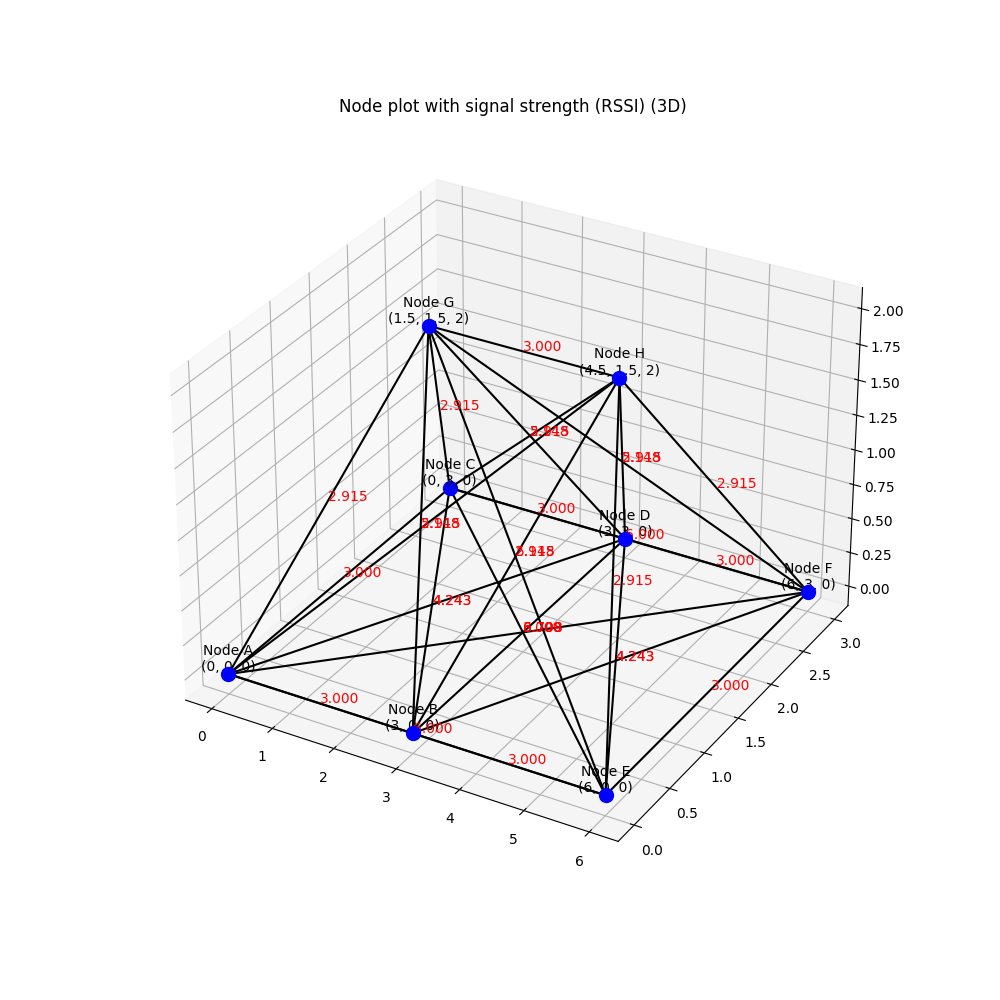

In [30]:
nodeList = []
RefNodeCoords = [(0,0,0),(3,0,0),(0,3,0),(3,3,0),(6,0,0),(6,3,0),(1.5,1.5,2),(4.5,1.5,2)]
# RefNodeCoords = [(0,0,0),(4,0,0),(3.5,2,2),(1.5,3,1)]

names = list(map(chr,range(ord('A'),ord('Z')+1)))

for i in range(len(RefNodeCoords)): 
    nodeList.append(Node(names[i]))

printNodes(nodeList)

NetworkEdges = {}
for i in range(len(nodeList)):
    table = []
    for j in range(len(nodeList)):
        if nodeList[i] != nodeList[j]:
            table.append(Edge(nodeList[i], nodeList[j], distance_to_rssi(RefNodeCoords[i],RefNodeCoords[j])))
    table = sorted(table, key=lambda x: x.rssi, reverse=False) # if rssi set True
    NetworkEdges[nodeList[i].uuid] = table

print('Reference Network Edges:')
for key, edges in NetworkEdges.items():
    print(f'Node {key}:= Edges{edges}')

compareGraph3D(NetworkEdges,RefNodeCoords)

<h1> Main: getting all node data </h1>

In [31]:
# activate nodes, print function in parallel with Threading
maxTriangles = 50
thread_list = []
for i in range(len(nodeList)):
    thread = threading.Thread(target=nodeList[i].main, args=(NetworkEdges,maxTriangles))
    thread_list.append(thread)
    thread.start()

for thread in thread_list:
    thread.join()

Map Angle Failed!Map Angle Failed!
Map Angle Failed!
Map Angle Failed!
Map Angle Failed!
Map Angle Failed!

Map Angle Failed!
Map Angle Failed!
Map Angle Failed!
Map Angle Failed!
Map Angle Failed!
Map Angle Failed!
Map Angle Failed!
Map Angle Failed!
Map Angle Failed!
Map Angle Failed!
Map Angle Failed!
Map Angle Failed!
Map Angle Failed!
Map Angle Failed!
Map Angle Failed!
Map Angle Failed!
Map Angle Failed!
Map Angle Failed!
Map Angle Failed!
Map Angle Failed!
------------------------------------------------------------------------------------------------
Node uuid=E:(0, 0, 0) [:] Surrounding Nodes= C, A, G, D, F, B, H, Edgelist= (E,C,6.708), (E,A,6.000), (E,G,5.148), (E,D,4.243), (E,F,3.000), (E,B,3.000), (E,H,2.915)

TriangleList:
Triangle B|E|G: Area= 3.750, Edges= (E,G,5.148), (E,B,3.000), (G,B,2.915), Angles=(E,29.055), Altitude=(x=[(G,4.459),(B,1.543)], H=(E,2.572))
Triangle E|G|H: Area= 3.750, Edges= (E,G,5.148), (E,H,2.915), (G,H,3.000), Angles=(E,29.982), Altitude=(x=[(G,4.

<h1> Visualizing node data </h1>

In [32]:
# Planar Roll rotation X
def roll(phi):
    phi = np.deg2rad(phi)
    return np.array([[1, 0, 0],
                     [0, np.cos(phi), -np.sin(phi)],
                     [0, np.sin(phi), np.cos(phi)]])

# Planar PITCH rotation Y
def pitch(theta):
    theta = np.deg2rad(theta)
    return np.array([[np.cos(theta), 0, np.sin(theta)],
                     [0, 1, 0],
                     [-np.sin(theta), 0, np.cos(theta)]])

# Planar YAW rotation Z
def yaw(psi):
    psi = np.deg2rad(psi)
    return np.array([[np.cos(psi), -np.sin(psi), 0],
                    [np.sin(psi), np.cos(psi), 0],
                    [0, 0, 1]])

In [33]:
def mapPlot(Edge_list, node_Dict):
    G = nx.Graph()

    for node in node_Dict.items():
        G.add_node(node[0], pos=node[1])

    for edge in Edge_list:
        G.add_edge(edge.src.uuid, edge.dst.uuid, Rssi=edge.rssi)

    pos = nx.get_node_attributes(G, 'pos')
    rssi = nx.get_edge_attributes(G, "Rssi")

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')  # Create a 3D axis

    # Draw nodes as scatter plot and text labels
    for nodeID, coords in pos.items():
        ax.scatter(*coords, c="blue", s=100, marker='o')
        ax.text(*coords, f'Node {nodeID}\n({coords[0]}, {coords[1]}, {coords[2]})', ha='center', va='bottom')

    # Draw edges in 3D
    for edge in G.edges():
        xs, ys, zs = zip(*[pos[edge[i]] for i in range(2)])
        ax.plot(xs, ys, zs, color='black')
        rssi_value = rssi.get(edge, "")
        ax.text(sum(xs)/2,sum(ys)/2,sum(zs)/2, f"{rssi_value:.3f}", color='red')

    ax.set_title("Adjacent map of visible nodes (3D)")
    plt.show()

A :=> Base edge: ('A', 'E'):
Triangle(A|E|G): base-coord=(E,6.000), map angle= 0.000 | xpos altitude=(A,1.500) | altitude height=(G,2.500) 
Triangle(A|E|H): base-coord=(X,0.000), map angle= 0.000 | xpos altitude=(A,4.500) | altitude height=(H,2.500) 
Triangle(A|D|E): base-coord=(X,0.000), map angle= 53.130 | xpos altitude=(A,3.000) | altitude height=(D,3.000) 
Triangle(A|E|F): base-coord=(X,0.000), map angle= 53.130 | xpos altitude=(A,6.000) | altitude height=(F,3.000) 
Triangle(A|C|E): base-coord=(X,0.000), map angle= 53.130 | xpos altitude=(A,0.000) | altitude height=(C,3.000) 

Plotting nodes (x,y,z) with respect to the base edge:
Node A: (0.000,0.000,0.000)
Node C: (0.000,1.800,2.400)
Node D: (3.000,1.800,2.400)
Node E: (6.000,0.000,0.000)
Node F: (6.000,1.800,2.400)
Node G: (1.500,2.500,0.000)
Node H: (4.500,2.500,0.000)

All edges from base triangles (11):
(A,E,6.000)
(A,G,2.915)
(E,G,5.148)
(A,H,5.148)
(E,H,2.915)
(A,D,4.243)
(E,D,4.243)
(A,F,6.708)
(F,E,3.000)
(A,C,3.000)
(E,C,

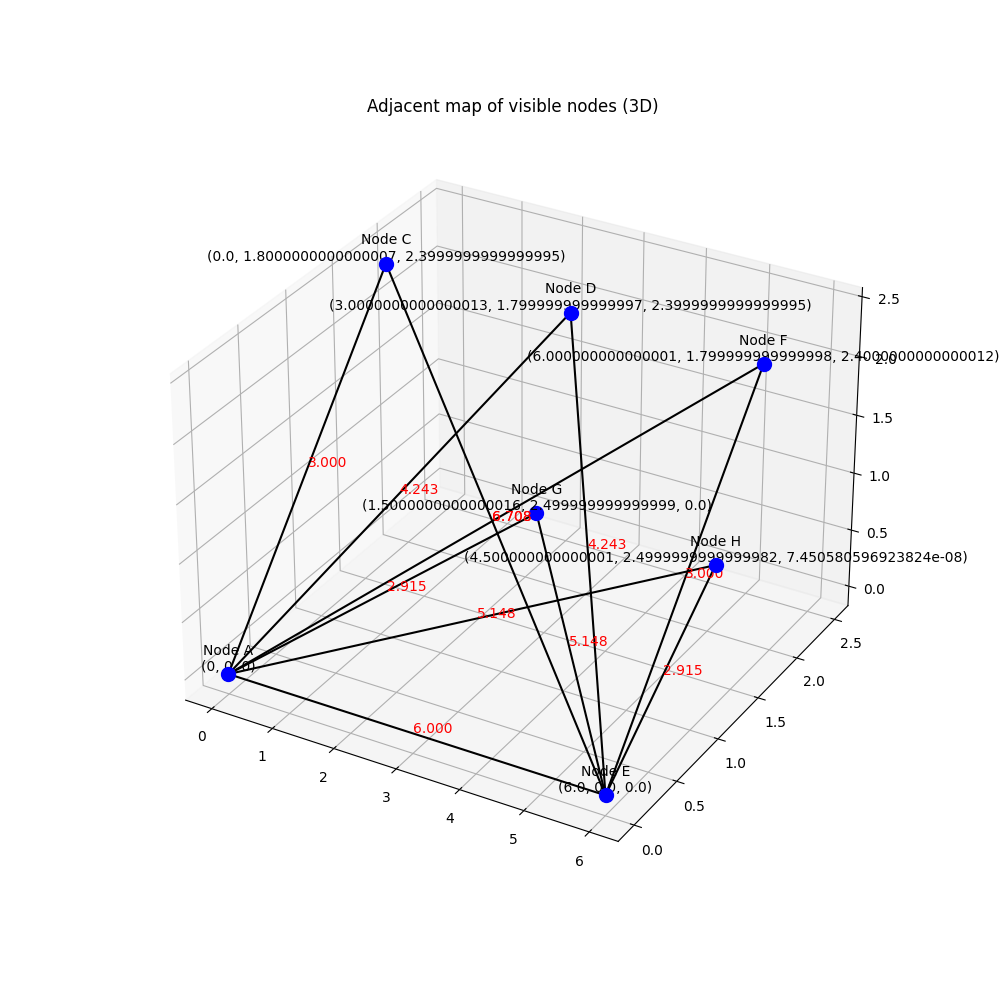

In [34]:
nodeA = nodeList[0]
index = 1

keyA0 = list(nodeA.adjTrianglesDict.keys())[index]
adjListA = list(nodeA.adjTrianglesDict.values())[index]

print(f'A :=> Base edge: {keyA0.id}:')
for adj in adjListA:
    print(adj)
print()

mapCoords = {nodeA.uuid: nodeA.coord,}

mapEdgeSet = []
# go over all triangles and place the coords on the x-axis and rotate, also make list of all edges from all adj triangles
for i, adj in enumerate(adjListA):
    if i == 0:
        mapCoords.update({adj.otherCoord[0]:(adj.otherCoord[1],0.000,0.000)})
    
    coord = (adj.basealtiX[1],adj.basealtiH[1],0.000) 
    rotation = roll(adj.mapAngle)
    point = np.array([coord[0], coord[1], coord[2]])    
    translated = np.dot(rotation, point)
    mapCoords.update({adj.basealtiH[0]:(translated[0],translated[1],translated[2])})

    mapEdgeSet.extend(edge for edge in adj.triangle.edges if not any(edge.compare(existing_edge) for existing_edge in mapEdgeSet))

sorted_mapCoords = dict(sorted(mapCoords.items()))

print('Plotting nodes (x,y,z) with respect to the base edge:')
for coord in sorted_mapCoords.items():
    print(f"Node {coord[0]}: ({coord[1][0]:.3f},{coord[1][1]:.3f},{coord[1][2]:.3f})")
print()

print(f"All edges from base triangles ({len(mapEdgeSet)}):")
for edge in list(mapEdgeSet):
    print(edge)

mapPlot(list(mapEdgeSet),mapCoords)

In [35]:
# ------------------------------------------------------------------------------------------------
# Node uuid=A:(0, 0, 0) [:] Surrounding Nodes= D, B, C, Edgelist= (A,D,3.500), (A,B,4.000), (A,C,4.500)

# TriangleList:
# Triangle A|C|D: Area= 4.257, Edges= (A,D,3.500), (A,C,4.500), (D,C,2.449), Angles=(A,32.726), Altitude=(x=[(D,0.408),(C,2.858)], H=(A,3.476))
# Triangle A|B|C: Area= 5.657, Edges= (A,B,4.000), (A,C,4.500), (B,C,2.872), Angles=(A,38.942), Altitude=(x=[(B,0.696),(C,2.176)], H=(A,3.939))
# Triangle A|B|D: Area= 6.325, Edges= (A,D,3.500), (A,B,4.000), (D,B,4.031), Angles=(A,64.623), Altitude=(x=[(D,1.550),(B,2.481)], H=(A,3.138))

# Opposite edges=(D,C,2.449), (B,C,2.872), (D,B,4.031) [:]

# Adjacent triangles of A:
# Edge ('A', 'D'):
# Triangle(A|C|D): base-coord=(D,3.500), map angle= 0.000 | xpos altitude=(A,3.786) | altitude height=(C,2.433) 
# Triangle(A|B|D): base-coord=(X,0.000), map angle= 31.329 | xpos altitude=(A,1.714) | altitude height=(B,3.614) 
# Edge ('A', 'B'):
# Triangle(A|B|C): base-coord=(B,4.000), map angle= 0.000 | xpos altitude=(A,3.500) | altitude height=(C,2.828) 
# Triangle(A|B|D): base-coord=(X,0.000), map angle= 26.565 | xpos altitude=(A,1.500) | altitude height=(D,3.162) 
# Edge ('A', 'C'):
# Triangle(A|C|D): base-coord=(C,4.500), map angle= 0.000 | xpos altitude=(A,2.944) | altitude height=(D,1.892) 
# Triangle(A|B|C): base-coord=(X,0.000), map angle= 131.634 | xpos altitude=(A,3.111) | altitude height=(B,2.514) 
# ------------------------------------------------------------------------------------------------